# Training and deploying a tabular model using Vertex custom training job

![Training pipeline](../images/custom-tabular.png)

## Import the required packages

In [1]:
import os
import pandas as pd
import tensorflow as tf

import matplotlib.pyplot as plt

from google.cloud import aiplatform as vertex_ai
from google.cloud.aiplatform_v1beta1 import types
from google.cloud import bigquery
from google.cloud import exceptions

from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

from tensorflow_io import bigquery as tfio_bq


In [2]:
print(tf.__version__)


2.4.1


## Configure GCP settings

*Before running the notebook make sure to follow the repo's README file to install the pre-requisites and configure GCP authentication.*

In [3]:
PROJECT = 'jk-mlops-dev'
REGION = 'us-central1'
STAGING_BUCKET = 'gs://jk-vertex-workshop-bucket'
VERTEX_SA = 'vertex-sa@jk-mlops-dev.iam.gserviceaccount.com'

## Initialize Vertex AI SDK

In [4]:
vertex_ai.init(
    project=PROJECT,
    location=REGION,
    staging_bucket=STAGING_BUCKET
)

## Create or set Tensorboard

In [5]:
tb_client = api_client = vertex_ai.initializer.global_config.create_client(
        client_class=vertex_ai.utils.TensorboardClientWithOverride, location_override=REGION
)
parent = f'projects/{PROJECT}/locations/{REGION}'

tensorboard_display_name = 'Workshop Tensorboard'
tensorboard_ref = None

for tensorboard in tb_client.list_tensorboards(parent=parent):
    if tensorboard.display_name == tensorboard_display_name:
        tensorboard_ref = tensorboard
        
if not tensorboard_ref:
    print('Creating new Tensorboard')
    tb_specs = types.Tensorboard(
        display_name=tensorboard_display_name,
        description=tensorboard_display_name
    )
    operation = tb_client.create_tensorboard(parent=parent, tensorboard=tb_specs)
    tensorboard_ref = operation.result()
else:
    print('Using existing Tensorboard:', tensorboard_ref.name)

Using existing Tensorboard: projects/895222332033/locations/us-central1/tensorboards/7964545572260544512


## Prepare training data in BigQuery

### Explore Chicago Taxi dataset

In [6]:
%%bigquery 

SELECT 
    *
FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
LIMIT 5

Downloading: 100%|██████████| 5/5 [00:01<00:00,  4.88rows/s]


,unique_key,taxi_id,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,pickup_community_area,dropoff_community_area,...,extras,trip_total,payment_type,company,pickup_latitude,pickup_longitude,pickup_location,dropoff_latitude,dropoff_longitude,dropoff_location
0,85a14cc9eea7ab0a4e5e8b4422a90d5a3ab56cd8,a38d173f3d3a362a9622b11153393dced7724f53b9c20c...,2017-05-31 23:00:00+00:00,2017-05-31 23:15:00+00:00,240.0,1.0,NaN,NaN,NaN,NaN,...,0.0,5.75,Cash,Sun Taxi,NaN,NaN,None,NaN,NaN,None
1,a1ef8a4059feeb5b4f1286631bd7dc196543a192,bd148166cee8cd0aa6477ae76e191ac3ac647166ff5a86...,2013-04-23 19:15:00+00:00,2013-04-23 19:15:00+00:00,120.0,0.0,NaN,NaN,NaN,NaN,...,0.0,44.65,Credit Card,Taxi Affiliation Services,NaN,NaN,None,NaN,NaN,None
2,9f2a2bf876f29e11b40b717697670c824cea9fb2,d77e1fd49af50352f8edfea8dd8431dc6799973a4e213c...,2013-04-22 11:00:00+00:00,2013-04-22 11:00:00+00:00,NaN,0.0,NaN,NaN,NaN,NaN,...,0.0,5.82,Credit Card,Chicago Elite Cab Corp.,NaN,NaN,None,NaN,NaN,None
3,2c27b4782da78e813c5a3478348ef155b25abf41,372f8083a96d9948939ad4060d2a968230d66bb02eaa91...,2013-04-20 02:45:00+00:00,2013-04-20 02:45:00+00:00,540.0,0.0,NaN,NaN,NaN,NaN,...,0.0,7.25,Cash,Northwest Management LLC,NaN,NaN,None,NaN,NaN,None
4,d60fc178fb8e4a72d9b1f37d3ee2373ee3d62e3a,6ea30df39193e64e233482c462ec66c63e8ed60c4c7f59...,2013-04-20 05:15:00+00:00,2013-04-20 05:15:00+00:00,0.0,0.0,NaN,NaN,NaN,NaN,...,0.0,16.38,Credit Card,Chicago Elite Cab Corp.,NaN,NaN,None,NaN,NaN,None


In [7]:
%%bigquery data

SELECT 
    CAST(EXTRACT(DAYOFWEEK FROM trip_start_timestamp) AS string) AS trip_dayofweek, 
    FORMAT_DATE('%A',cast(trip_start_timestamp as date)) AS trip_dayname,
    COUNT(*) as trip_count,
FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
WHERE
    EXTRACT(YEAR FROM trip_start_timestamp) = 2015 
GROUP BY
    trip_dayofweek,
    trip_dayname
ORDER BY
    trip_dayofweek

Downloading: 100%|██████████| 7/7 [00:00<00:00,  7.03rows/s]


In [8]:
data

,trip_dayofweek,trip_dayname,trip_count
0,1,Sunday,4141154
1,2,Monday,4105900
2,3,Tuesday,4378805
3,4,Wednesday,4542810
4,5,Thursday,4918190
5,6,Friday,5289830
6,7,Saturday,5009186


<AxesSubplot:xlabel='trip_dayname'>

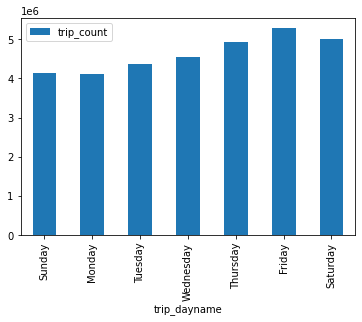

In [9]:
data.plot(kind='bar', x='trip_dayname', y='trip_count')

### Creating training and validation splits

In [10]:
BQ_DATASET_NAME = 'training_dataset' # Change to your BQ datasent name.
BQ_TABLE_NAME = 'training_table'
BQ_LOCATION = 'US'

#### Create a training dataset

In [11]:
client = bigquery.Client()

dataset_id = f'{PROJECT}.{BQ_DATASET_NAME}'
dataset = bigquery.Dataset(dataset_id)
dataset.location = BQ_LOCATION

try:
    dataset = client.create_dataset(dataset, timeout=30)
    print('Created dataset: ', dataset_id)
except exceptions.Conflict:
    print('Dataset {} already exists'.format(dataset_id))

Dataset jk-mlops-dev.training_dataset already exists


#### Create a training table

In [12]:
sample_size = 1000000
year = 2020

sql_script = '''
CREATE OR REPLACE TABLE `@PROJECT.@DATASET.@TABLE` 
AS (
    WITH
      taxitrips AS (
      SELECT
        FORMAT_DATETIME('%Y-%d-%m', trip_start_timestamp) AS date,
        trip_start_timestamp,
        trip_seconds,
        trip_miles,
        payment_type,
        pickup_longitude,
        pickup_latitude,
        dropoff_longitude,
        dropoff_latitude,
        tips,
        fare
      FROM
        `bigquery-public-data.chicago_taxi_trips.taxi_trips`
      WHERE 1=1 
      AND pickup_longitude IS NOT NULL
      AND pickup_latitude IS NOT NULL
      AND dropoff_longitude IS NOT NULL
      AND dropoff_latitude IS NOT NULL
      AND trip_miles > 0
      AND trip_seconds > 0
      AND fare > 0
      AND EXTRACT(YEAR FROM trip_start_timestamp) = @YEAR
    )

    SELECT
      trip_start_timestamp,
      EXTRACT(MONTH from trip_start_timestamp) as trip_month,
      EXTRACT(DAY from trip_start_timestamp) as trip_day,
      EXTRACT(DAYOFWEEK from trip_start_timestamp) as trip_day_of_week,
      EXTRACT(HOUR from trip_start_timestamp) as trip_hour,
      trip_seconds,
      trip_miles,
      payment_type,
      ST_AsText(
          ST_SnapToGrid(ST_GeogPoint(pickup_longitude, pickup_latitude), 0.1)
      ) AS pickup_grid,
      ST_AsText(
          ST_SnapToGrid(ST_GeogPoint(dropoff_longitude, dropoff_latitude), 0.1)
      ) AS dropoff_grid,
      ST_Distance(
          ST_GeogPoint(pickup_longitude, pickup_latitude), 
          ST_GeogPoint(dropoff_longitude, dropoff_latitude)
      ) AS euclidean,
      IF((tips/fare >= 0.2), 1, 0) AS tip_bin,
      CASE (ABS(MOD(FARM_FINGERPRINT(date),10))) 
          WHEN 9 THEN 'testing'
          WHEN 8 THEN 'validation'
          ELSE 'training' END AS data_split
    FROM
      taxitrips
    LIMIT @LIMIT
)
'''

sql_script = sql_script.replace(
    '@PROJECT', PROJECT).replace(
    '@DATASET', BQ_DATASET_NAME).replace(
    '@TABLE', BQ_TABLE_NAME).replace(
    '@YEAR', str(year)).replace(
    '@LIMIT', str(sample_size))


In [13]:
job = client.query(sql_script)
job.result()

In [14]:
sql_script = f'''
SELECT * 
FROM {PROJECT}.{BQ_DATASET_NAME}.{BQ_TABLE_NAME} 
WHERE data_split='training'
'''
training_data = client.query(sql_script).result().to_dataframe()

In [15]:
training_data.head(3)

,trip_start_timestamp,trip_month,trip_day,trip_day_of_week,trip_hour,trip_seconds,trip_miles,payment_type,pickup_grid,dropoff_grid,euclidean,tip_bin,data_split
0,2020-06-19 00:00:00+00:00,6,19,6,0,1200,4.1,Cash,POINT(-87.6 41.8),POINT(-87.7 41.9),2210.049904,0,training
1,2020-06-19 00:00:00+00:00,6,19,6,0,240,0.9,Cash,POINT(-87.7 42),POINT(-87.7 42),2406.040979,0,training
2,2020-06-19 00:00:00+00:00,6,19,6,0,660,1.1,Cash,POINT(-87.7 41.9),POINT(-87.6 41.9),3788.783830,0,training


In [16]:
sql_script = f'''
SELECT ARRAY(SELECT DISTINCT payment_type FROM {PROJECT}.{BQ_DATASET_NAME}.{BQ_TABLE_NAME}) as payment_type_vocab,
       ARRAY(SELECT DISTINCT pickup_grid FROM {PROJECT}.{BQ_DATASET_NAME}.{BQ_TABLE_NAME}) as pickup_grid_vocab,
       ARRAY(SELECT DISTINCT dropoff_grid FROM {PROJECT}.{BQ_DATASET_NAME}.{BQ_TABLE_NAME}) as dropoff_grid_vocab,
       (SELECT AS STRUCT AVG(trip_seconds), VARIANCE(trip_seconds) FROM {PROJECT}.{BQ_DATASET_NAME}.{BQ_TABLE_NAME}) as trip_seconds_stats,
'''

training_data_stats = client.query(sql_script).result().to_dataframe()
training_data_stats.T

,0
payment_type_vocab,"[Cash, Prcard, Credit Card, Unknown, Mobile, D..."
pickup_grid_vocab,"[POINT(-87.6 41.8), POINT(-87.7 42), POINT(-87..."
dropoff_grid_vocab,"[POINT(-87.7 41.9), POINT(-87.7 42), POINT(-87..."
trip_seconds_stats,"{'_field_1': 873.2935509999938, '_field_2': 21..."


In [17]:
sql_script = f'''
SELECT * EXCEPT (trip_start_timestamp, data_split)
FROM {PROJECT}.{BQ_DATASET_NAME}.{BQ_TABLE_NAME} 
'''
sample_data = client.query(sql_script).result().to_dataframe()

In [18]:
sample_data.head().T

,0,1,2,3,4
trip_month,6,6,6,6,6
trip_day,19,19,19,19,19
trip_day_of_week,6,6,6,6,6
trip_hour,0,0,0,0,0
trip_seconds,1200,240,660,1780,480
trip_miles,4.1,0.9,1.1,9.64,1.5
payment_type,Cash,Cash,Cash,Prcard,Cash
pickup_grid,POINT(-87.6 41.8),POINT(-87.7 42),POINT(-87.7 41.9),POINT(-87.7 41.8),POINT(-87.6 41.9)
dropoff_grid,POINT(-87.7 41.9),POINT(-87.7 42),POINT(-87.6 41.9),POINT(-87.6 41.7),POINT(-87.6 41.9)
euclidean,2210.049904,2406.040979,3788.78383,12414.729032,0.0


In [19]:
sample_data.tip_bin.value_counts()

0    638303
1    361697
Name: tip_bin, dtype: int64

<AxesSubplot:>

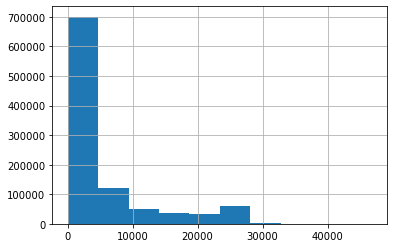

In [20]:
sample_data.euclidean.hist()

In [21]:
sql_script = f'''
SELECT * 
FROM {PROJECT}.{BQ_DATASET_NAME}.{BQ_TABLE_NAME} 
WHERE data_split='training'
'''
training_data = client.query(sql_script).result().to_dataframe()

In [22]:
training_data.data_split.value_counts()

training    705690
Name: data_split, dtype: int64

In [23]:
training_data.trip_miles.mean()

3.889216908275587

## Prepare the model

In [24]:
FEATURES = {
    "tip_bin": ("categorical", tf.int64),
    "trip_month": ("categorical", tf.int64),
    "trip_day": ("categorical", tf.int64),
    "trip_day_of_week": ("categorical", tf.int64),
    "trip_hour": ("categorical", tf.int64),
    "payment_type": ("categorical", tf.string),
    "pickup_grid": ("categorical", tf.string),
    "dropoff_grid": ("categorical", tf.string),
    "euclidean": ("numeric", tf.double),
    "trip_seconds": ("numeric", tf.int64),
    "trip_miles": ("numeric", tf.double),
}

TARGET_FEATURE_NAME = "tip_bin"

TARGET_LABELS = ["tip<20%", "tip>=20%"]


In [48]:
max_tokens = None

preprocessing.IntegerLookup(max_values=max_tokens)

In [54]:
def get_bq_dataset(project_id, dataset_id, table_id, selected_fields, batch_size):

    client = tfio_bq.BigQueryClient()
    parent = f'projects/{project_id}'

    read_session = client.read_session(
        parent=parent,
        project_id=project_id,
        table_id=table_id,
        dataset_id=dataset_id,
        selected_fields=selected_fields,
    )

    dataset = read_session.parallel_read_rows().batch(batch_size)
    
    return dataset


def get_category_encoding_layer(name, dataset, dtype):
    """Creates a CategoryEncoding layer for a given feature."""

    if dtype == tf.string:
      index = preprocessing.StringLookup()
    else:
      index = preprocessing.IntegerLookup()

    feature_ds = dataset.map(lambda x: x[name])
    index.adapt(feature_ds)
    
    print(index.get_vocabulary())
    encoder = preprocessing.CategoryEncoding(max_tokens=index.vocab_size())

    return lambda feature: encoder(index(feature))


def get_normalization_layer(name, dataset):
  """"Creates a Normalization layer for a given feature."""
  normalizer = preprocessing.Normalization()

  feature_ds = dataset.map(lambda x: x[name])
  normalizer.adapt(feature_ds)

  return normalizer


def create_model(dataset, units, dropout_ratio):
    """Creates a binary classifier for Chicago Taxi tip prediction task."""
    
    all_inputs = []
    encoded_features = []
    for feature_name, feature_info in FEATURES.items():
        col = tf.keras.Input(shape=(1,), name=feature_name, dtype=feature_info[1])
        if feature_info[0] == 'categorical':
            
            encoding_layer = get_category_encoding_layer(feature_name, 
                                                         dataset,
                                                         feature_info[1])
        else:
            encoding_layer = get_normalization_layer(feature_name,
                                                     dataset) 
        encoded_col = encoding_layer(col)
        all_inputs.append(col)
        encoded_features.append(encoded_col)
        
    all_features = tf.keras.layers.concatenate(encoded_features)
    
    x = tf.keras.layers.Dense(units, activation="relu")(all_features)
    x = tf.keras.layers.Dropout(dropout_ratio)(x)
    output = tf.keras.layers.Dense(1)(x)
    model = tf.keras.Model(all_inputs, output)
    
    return model
            

[0, -1, 1]
[0, -1, 2, 6, 5, 10, 8, 9, 12, 4, 1, 7, 11, 3]
[0, -1, 20, 13, 14, 21, 19, 27, 28, 6, 12, 26, 5, 25, 7, 18, 11, 4, 24, 10, 3, 15, 17, 22, 16, 8, 23, 1, 9, 2, 30, 29, 31]
[0, -1, 5, 6, 4, 3, 2, 7, 1]
[0, -1, 17, 18, 16, 15, 13, 14, 19, 12, 11, 9, 10, 8, 20, 21, 22, 7, 23, 6, 1, 2, 3, 5, 4]
['', '[UNK]', 'Credit Card', 'Cash', 'Prcard', 'Unknown', 'Mobile', 'No Charge', 'Dispute', 'Prepaid']
['', '[UNK]', 'POINT(-87.6 41.9)', 'POINT(-87.7 41.9)', 'POINT(-87.9 42)', 'POINT(-87.7 42)', 'POINT(-87.6 41.8)', 'POINT(-87.8 41.8)', 'POINT(-87.6 41.7)', 'POINT(-87.8 42)', 'POINT(-87.7 41.8)', 'POINT(-87.8 41.9)', 'POINT(-87.7 41.7)', 'POINT(-87.6 42)', 'POINT(-87.5 41.7)']
['', '[UNK]', 'POINT(-87.6 41.9)', 'POINT(-87.7 41.9)', 'POINT(-87.7 42)', 'POINT(-87.6 41.8)', 'POINT(-87.9 42)', 'POINT(-87.6 41.7)', 'POINT(-87.8 42)', 'POINT(-87.8 41.8)', 'POINT(-87.7 41.8)', 'POINT(-87.8 41.9)', 'POINT(-87.7 41.7)', 'POINT(-87.6 42)', 'POINT(-87.5 41.7)']


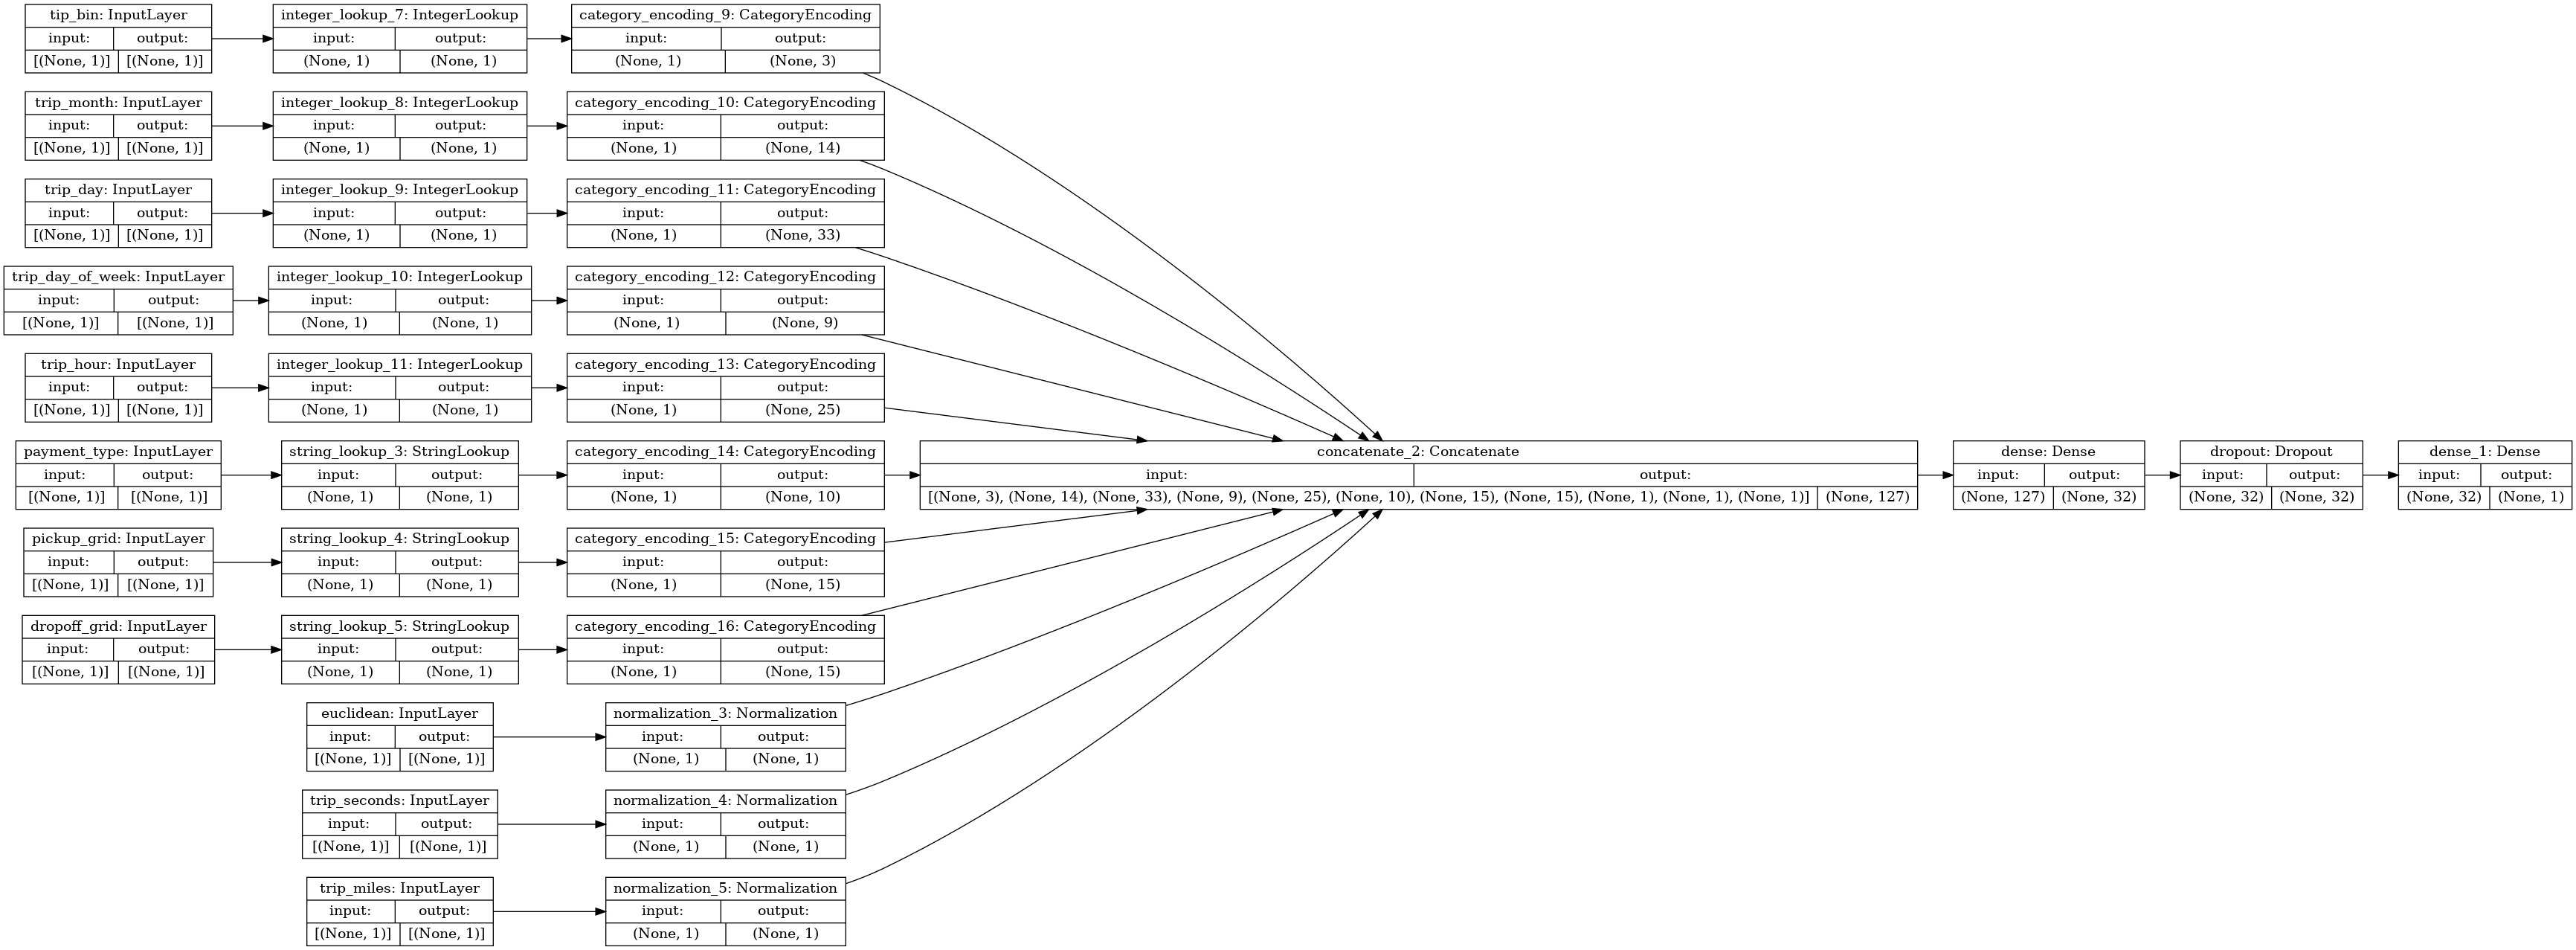

In [55]:
model = create_model(dataset, 32, 0.5)
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

In [38]:
selected_fields = {key: {'output_type': value[1]} for key, value in FEATURES.items()}

dataset = get_bq_dataset(PROJECT, BQ_DATASET_NAME, BQ_TABLE_NAME, selected_fields, 32)

## Create a Vertex managed tabular dataset

### List existing tabular datasets

In [ ]:
display_name = 'Chicago Taxi Tips'
filter = 'display_name="{}"'.format(display_name)

for dataset in vertex_ai.TabularDataset.list(filter=filter):
    print(dataset.display_name, ' : ', dataset.resource_name)

### Create a new tabular dataset based on the BigQuery table

In [ ]:
bq_source = f'bq://{PROJECT}.{BQ_DATASET_NAME}.{BQ_TABLE_NAME}'


dataset = vertex_ai.TabularDataset.create(
    display_name=display_name, bq_source=bq_source
)

## Prepare a training script

In [ ]:
folder = 'trainer'
if tf.io.gfile.exists(folder):
    tf.io.gfile.rmtree(folder)
tf.io.gfile.mkdir(folder)
file_path = os.path.join(folder, 'train.py')

In [ ]:
%%writefile {file_path}


# Copyright 2021 Google Inc. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#            http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and

import tensorflow as tf
from tensorflow import keras

from absl import app
from absl import flags
from absl import logging

FEATURE_NAMES = [
    "trip_month",
    "trip_day",
    "trip_day_of_week",
    "trip_hour",
    "trip_seconds",
    "trip_miles",
    "payment_type",
    "pickup_grid",
    "dropoff_grid",
    "euclidean",
    "loc_cross",
]

TARGET_FEATURE_NAME = "tip_bin"

TARGET_LABELS = ["tip<20%", "tip>=20%"]

NUMERICAL_FEATURE_NAMES = [
    "trip_seconds",
    "trip_miles",
    "euclidean",
]

EMBEDDING_CATEGORICAL_FEATURES = {
    "trip_month": 2,
    "trip_day": 4,
    "trip_hour": 3,
    "pickup_grid": 3,
    "dropoff_grid": 3,
    "loc_cross": 10,
}

ONEHOT_CATEGORICAL_FEATURE_NAMES = ["payment_type", "trip_day_of_week"]

def create_model_inputs():
    inputs = {}
    for name in NUMERICAL_FEATURE_NAMES:
        inputs[name] = keras.layers.Input(name=name, shape=[], dtype=tf.float32)
    for name in list(EMBEDDING_CATEGORICAL_FEATURES.keys()) + ONEHOT_CATEGORICAL_FEATURE_NAMES:
        inputs[name] = keras.layers.Input(name=name, shape=[], dtype=tf.int64)
    return inputs


def create_binary_classifier(feature_vocab_sizes, hyperparams):
    input_layers = create_model_inputs()

    layers = []
    for feature_name in input_layers.keys:
        if feature_name in EMBEDDING_CATEGORICAL_FEATURES:
            vocab_size = feature_vocab_sizes[feature_name]
            embedding_size = EMBEDDING_CATEGORICAL_FEATURES[feature_name]
            embedding_output = keras.layers.Embedding(
                input_dim=vocab_size + 1,
                output_dim=embedding_size,
                name=f"{feature_name}_embedding",
            )(input_layers[feature_name])
            layers.append(embedding_output)
        elif feature_name in ONEHOT_CATEGORICAL_FEATURE_NAMES:
            vocab_size = feature_vocab_sizes[feature_name]
            onehot_layer = keras.layers.experimental.preprocessing.CategoryEncoding(
                max_tokens=vocab_size,
                output_mode="binary",
                name=f"{feature_name}_onehot",
            )(input_layers[feature_name])
            layers.append(onehot_layer)
        elif feature_name in NUMERICAL_FEATURE_NAMES:
            numeric_layer = tf.expand_dims(input_layers[feature_name], -1)
            layers.append(numeric_layer)
        else:
            pass

    joined = keras.layers.Concatenate(name="combines_inputs")(layers)
    feedforward_output = keras.Sequential(
        [
            keras.layers.Dense(units, activation="relu")
            for units in hyperparams["hidden_units"]
        ],
        name="feedforward_network",
    )(joined)
    logits = keras.layers.Dense(units=1, name="logits")(feedforward_output)

    model = keras.Model(inputs=input_layers, outputs=[logits])
    return model


def main(argv):
    del argv
    
    inputs = create_model_inputs()
    print(inputs)

if __name__ == '__main__':
    logging.set_verbosity(logging.INFO)
    app.run(main)